In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



# Load the dataset
df = pd.read_csv("data/raw/telco-customer-churn.csv")

In [2]:
print("Number of missing values in TotalCharges:", df["TotalCharges"].isnull().sum())


Number of missing values in TotalCharges: 0


In [7]:
print(df['TotalCharges'].dtype)  # Should now be `float64`


object


In [8]:
df[df["TotalCharges"].str.strip() == ""]


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [9]:
(df["TotalCharges"].str.strip() == "").sum()


11

In [12]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
# For missing values, use the correct calculation: MonthlyCharges * tenure
df["TotalCharges"].fillna(df["MonthlyCharges"] * df["tenure"], inplace=True)


In [21]:
#recalculate totalcharges
df['TotalCharges'] = df.apply(
    lambda row: row['MonthlyCharges'] * (row['tenure'] - 1)
    if row['Churn'] == 'Yes'
    else row['MonthlyCharges'] * row['tenure'],
    axis=1
)


In [22]:
# 1. Target Distribution
print("Target Distribution (Churn):")
print(df["Churn"].value_counts(normalize=True))


Target Distribution (Churn):
No     0.73463
Yes    0.26537
Name: Churn, dtype: float64


In [5]:
# Impute missing TotalCharges with median (after converting to float)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
median_total_charges = df["TotalCharges"].median()
df["TotalCharges"].fillna(median_total_charges, inplace=True)


In [23]:
# Check if TotalCharges is now a float and has no missing values
print("Data type of TotalCharges:", df["TotalCharges"].dtype)
print("Number of missing values in TotalCharges:", df["TotalCharges"].isnull().sum())


# Display the first few rows to visually confirm imputation
print("\nFirst 5 rows of TotalCharges after imputation:")
print(df["TotalCharges"].head())

Data type of TotalCharges: float64
Number of missing values in TotalCharges: 0

First 5 rows of TotalCharges after imputation:
0      29.85
1    1936.30
2      53.85
3    1903.50
4      70.70
Name: TotalCharges, dtype: float64


In [24]:
# 3. Cardinality: Drop customerID (7,043 unique)
df.drop(columns=["customerID"], inplace=True)

In [25]:
# Check if customerID is in the DataFrame columns
print("Is 'customerID' in the DataFrame?", "customerID" in df.columns)

# Display the current columns to confirm
print("\nCurrent columns in the DataFrame:")
print(df.columns.tolist())


Is 'customerID' in the DataFrame? False

Current columns in the DataFrame:
['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


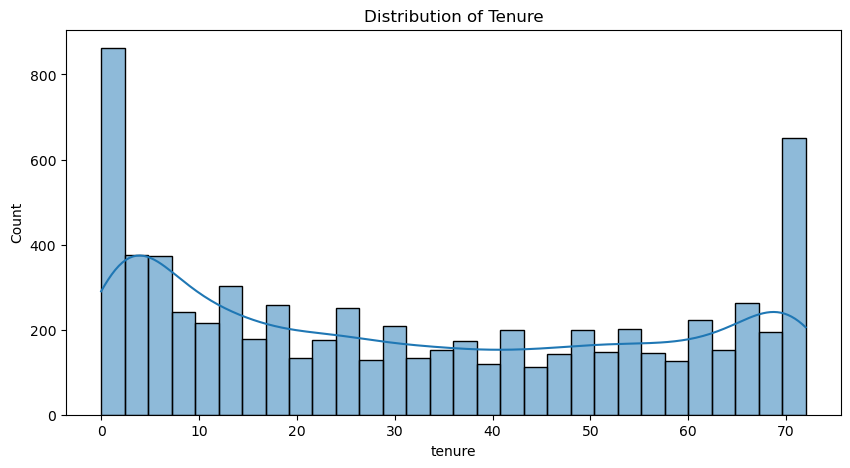

In [26]:
# 4. Numerical Distributions
# tenure: Check for uniform distribution
plt.figure(figsize=(10, 5))
sns.histplot(df["tenure"], bins=30, kde=True)
plt.title("Distribution of Tenure")
plt.show()

In [25]:
# Create tenure-based features
df["is_new_customer"] = df["tenure"].apply(lambda x: 1 if x <= 3 else 0)
df["is_long_term_customer"] = df["tenure"].apply(lambda x: 1 if x >= 60 else 0)

# Verify the new features
print(df[["tenure", "is_new_customer", "is_long_term_customer"]].head())


   tenure  is_new_customer  is_long_term_customer
0       1                1                      0
1      34                0                      0
2       2                1                      0
3      45                0                      0
4       2                1                      0


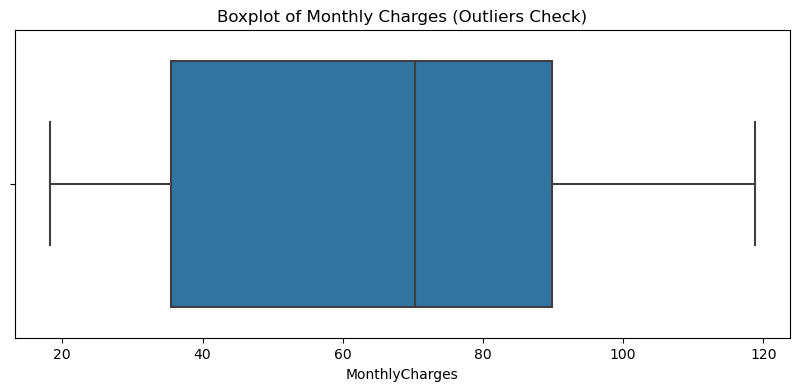

In [27]:
# MonthlyCharges: Look for outliers (> $100)
plt.figure(figsize=(10, 4))
sns.boxplot(x=df["MonthlyCharges"])
plt.title("Boxplot of Monthly Charges (Outliers Check)")
plt.show()

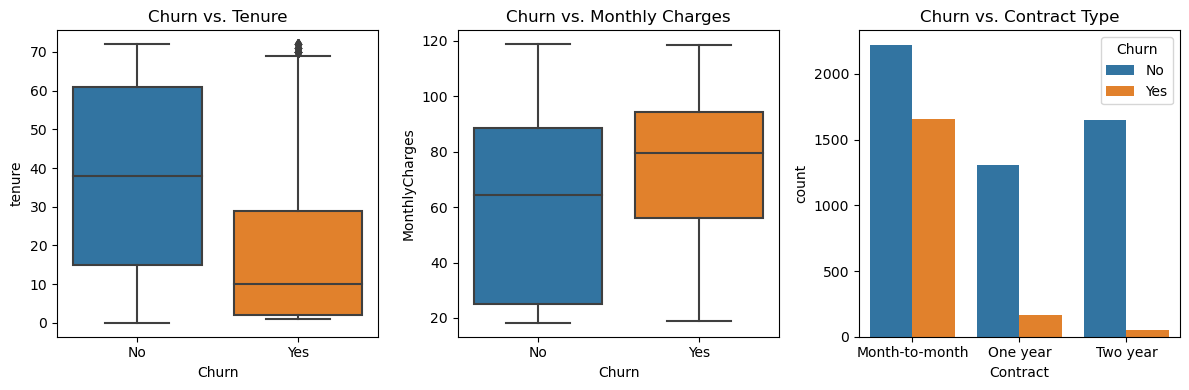

In [28]:
# 5. Correlations: Plot Churn vs. Contract, tenure, MonthlyCharges
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
sns.boxplot(x="Churn", y="tenure", data=df)
plt.title("Churn vs. Tenure")

plt.subplot(1, 3, 2)
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Churn vs. Monthly Charges")

plt.subplot(1, 3, 3)
sns.countplot(x="Contract", hue="Churn", data=df)
plt.title("Churn vs. Contract Type")
plt.tight_layout()
plt.show()




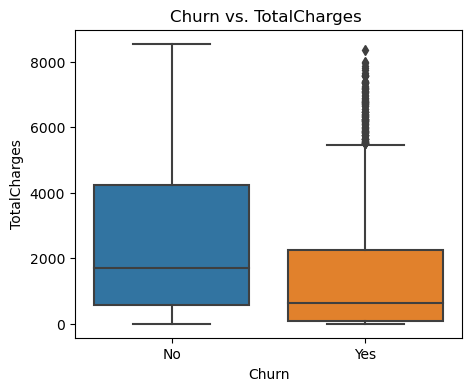

In [29]:
plt.figure(figsize=(5, 4))
sns.boxplot(x="Churn", y="TotalCharges", data=df)
plt.title("Churn vs. TotalCharges ")
plt.show()


In [30]:
from sklearn.preprocessing import OneHotEncoder

# Binary mappings
binary_map = {"Yes": 1, "No": 0}
gender_map = {"Male": 1, "Female": 0}

# Apply binary mappings to the DataFrame
df["Partner"] = df["Partner"].map(binary_map)
df["Dependents"] = df["Dependents"].map(binary_map)
df["PhoneService"] = df["PhoneService"].map(binary_map)
df["PaperlessBilling"] = df["PaperlessBilling"].map(binary_map)
df["gender"] = df["gender"].map(gender_map)

# Define features and target
X = df.drop(columns=["Churn"])
y = df["Churn"].map(binary_map)

# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define column types
binary_categorical_cols = ["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]
nominal_categorical_cols = ["InternetService", "Contract", "PaymentMethod", "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# Preprocessing for numeric columns
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

# Preprocessing for nominal categorical columns
nominal_categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Preprocessing for binary categorical columns (no transformation needed)
binary_categorical_transformer = Pipeline(
    steps=[
        ("passthrough", "passthrough")
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("nominal_cat", nominal_categorical_transformer, nominal_categorical_cols),
        ("binary_cat", binary_categorical_transformer, binary_categorical_cols),
    ]
)


In [31]:
#Baseline Model 
# Define models
from sklearn.metrics import accuracy_score

models = {
    "RandomForest": RandomForestClassifier(class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(scale_pos_weight=2.7, random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", model)
        ]
    )

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Predict on validation set
    y_pred = pipeline.predict(X_val)
    y_proba = pipeline.predict_proba(X_val)[:, 1]

    # Calculate metrics
    results[name] = {
        "Accuracy":accuracy_score(y_val, y_pred),
        "Recall": recall_score(y_val, y_pred),
        "Precision": precision_score(y_val, y_pred),
        "F1": f1_score(y_val, y_pred),
        "AUC-ROC": roc_auc_score(y_val, y_proba),
    }

In [36]:
# Print results
print("\nModel Comparison:")
for model_name, metrics in results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Model Comparison:

RandomForest:
Accuracy: 0.8155
Recall: 0.5428
Precision: 0.6952
F1: 0.6096
AUC-ROC: 0.8580

XGBoost:
Accuracy: 0.8432
Recall: 0.7460
Precision: 0.6889
F1: 0.7163
AUC-ROC: 0.9098


In [37]:
# Plot feature importance for the best model (XGBoost)
best_model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier(scale_pos_weight=2.7, random_state=42))
    ]
)
best_model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('nominal_cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Interne...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

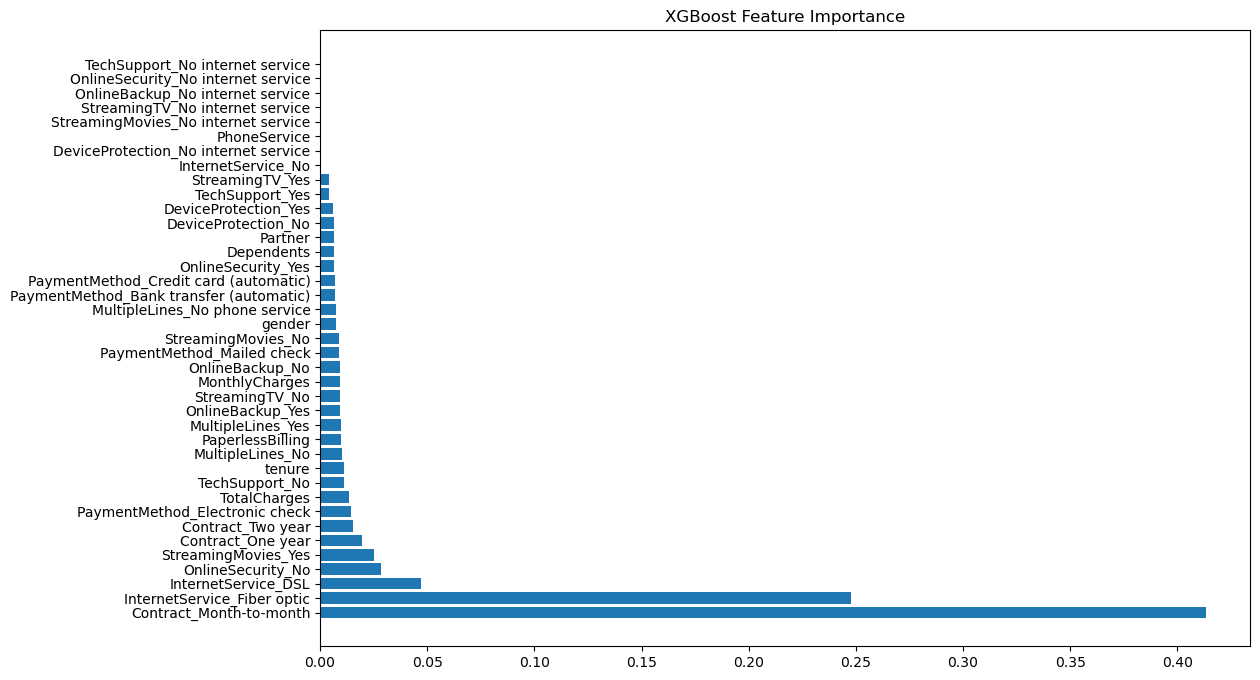

In [38]:
# Extract feature names after preprocessing
# Numeric feature names
feature_names = numeric_cols.copy()

# Nominal categorical feature names after one-hot encoding
nominal_cat_transformer = best_model_pipeline.named_steps["preprocessor"].named_transformers_["nominal_cat"]
ohe_feature_names = nominal_cat_transformer.named_steps["onehot"].get_feature_names_out(nominal_categorical_cols)
feature_names.extend(ohe_feature_names)

# Binary categorical feature names
binary_cat_cols = binary_categorical_cols.copy()
feature_names.extend(binary_cat_cols)

# Plot feature importance
plt.figure(figsize=(12, 8))
feat_importances = best_model_pipeline.named_steps["classifier"].feature_importances_
sorted_idx = np.argsort(feat_importances)[::-1]
plt.barh(range(len(sorted_idx)), feat_importances[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.title("XGBoost Feature Importance")
plt.show()
